In [1]:
import math
import re
from pathlib import Path
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
import sklearn.datasets as spd
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score
import random
import glob
from PIL import Image 
from tqdm import tqdm

## Data Preparation and Initialization

In [2]:
def generate_test_data(num_components=3, num_dims=2, num_cluster_points=100, range_limit=(-10, 10)):
    """
    Generates test data randomly
    :param num_components: how many components for the gaussian mixture model to initialize
    :param num_dims: how many dimensions every gaussian has
    :param num_cluster_points: how many points in every cluster
    :param range_limit: range_limit: lower and upper range limit for the parameter initialization, plot will have a range of +/- range_limit + 1/2 range_limit
    :return:
    """
    data = []
    mean = np.random.rand(num_components, num_dims) * (range_limit[1] - range_limit[0]) + range_limit[0]
    cov = None
    for i in range(num_components):
        cov = spd.make_spd_matrix(num_dims)
        data += list(np.random.multivariate_normal(mean[i], cov, num_cluster_points))
    data = np.array(data)
    return data, mean, cov


def initialize_random_components_params(num_components, num_dims):
    """
    Initializes the pi, mu and cov(sigma) for every cluster
    :param num_components: the number of components to "search for" in the mixture model
    :param num_dims: the number of dimensions
    :return: the initialized parameters
    """
    components_params = []

    for _ in range(0, num_components):
        components_params.append({
            'p': 1 / num_components,
            'm': np.random.normal(0, 1, size=(num_dims,)),
            's': spd.make_spd_matrix(num_dims)
        })
    return components_params

## Plotting and Visualization

In [3]:
def plot(data, components_params, fig, title, colors, range_limit=(-10, 10), w=0.1, plot=False, save=False):
    """
    Plotting function for visualizing the Algorithm, only works for 1 and 2 Dimensions!
    :param data: The data to plot
    :param components_params: The components_params to plot the estimated gaussians of TODO check if this is right
    :param fig: The Figure to Plot this on, this function is supposed to be called in many iterations, reinitializing kills your ram
    :param title: The title for the figures, also the name of the file if saved
    :param colors: the colors for the 2D plot
    :param range_limit: range_limit: lower and upper range limit for the parameter initialization, plot will have a range of +/- range_limit + 1/2 range_limit
    :param w: the width of the histogram bins, used to compute the number of bins
    :param plot: If True, shows the current figure
    :param save: If True, saves the current figure in ./images/
    """

    # One Dimension
    if len(components_params[0]["m"]) == 1:
        n_bins = math.ceil((data.max() - data.min()) / w)
        x = np.linspace(range_limit[0] + (range_limit[0] / 2), range_limit[1] + (range_limit[1] / 2), data.shape[0], )
        x = x.reshape(data.shape[0], 1)
        plt.hist(data, bins=n_bins, density=True)

        # create gaussian curves and also sum them up for the gaussian mixture
        gaussian_mixture = 0
        for param in components_params:
            gaussian = param["p"] * norm.pdf(x, loc=param["m"], scale=np.sqrt(param["s"]))
            plt.plot(x, gaussian, label="gaussian")
            gaussian_mixture += gaussian

        plt.plot(x, gaussian_mixture, color="black", linewidth=1.5, label="gaussian mixture")
        plt.legend()
        plt.title(title)

        if save:
            plt.savefig("./images/" + title.replace(':', '_').replace(' ', '_') + ".png")
        if plot:
            plt.show()

    # Two Dimension plotting implemented according to: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    if len(components_params[0]["m"]) == 2:

        ax = fig.gca()
        ax.scatter(data[:, 0], data[:, 1], s=3, alpha=0.4)
        ax.set_xlim((range_limit[0] + (range_limit[0] / 2), range_limit[1] + (range_limit[1] / 2)))
        ax.set_ylim((range_limit[0] + (range_limit[0] / 2), range_limit[1] + (range_limit[1] / 2)))
        plt.title(title)

        # Plot an elipse for every gaussian
        for color, param in zip(colors, components_params):
            pearson = param["s"][0, 1] / np.sqrt(param["s"][0, 0] * param["s"][1, 1])
            for i in range(1, 4): # some more depth to the plotting
                ell_radius_x = np.sqrt(1 + pearson)
                ell_radius_y = np.sqrt(1 - pearson)
                ellipse = Ellipse((0, 0),
                                  width=ell_radius_x * 2,
                                  height=ell_radius_y * 2,
                                  facecolor=color,
                                  alpha=0.2)
                scale_x = np.sqrt(param["s"][0, 0]) * i
                mean_x = param["m"][0]
                scale_y = np.sqrt(param["s"][1, 1]) * i
                mean_y = param["m"][1]
                transf = transforms.Affine2D() \
                    .rotate_deg(45) \
                    .scale(scale_x, scale_y) \
                    .translate(mean_x, mean_y)
                ellipse.set_transform(transf + ax.transData)
                ax.add_patch(ellipse)



        if save:
            plt.savefig("./images/" + title.replace(':', '_').replace(' ', '_') + ".png")
        if plot:
            plt.show()

    # clear figure
    plt.clf()


def save_as_gif(input_folder="./images/Iteration_*", output_folder="./gifs/iterations.gif"):
    """
    saves all images from the input_folder as one gif, sorts by numers in filename
    https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    :param input_folder: The directory to get all images from
    :param output_folder: The directory to save the created gif to
    """
    imgs = (Image.open(f) for f in sorted(glob.glob(input_folder), key=get_order))
    img = next(imgs)  # extract first image from iterator
    img.save(fp=output_folder, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)


def get_order(file):
    """
    For stop sorting like 1, 10, 100, 11 .. 19, 2, 20, 21 ...
    recklessly stolen from https://stackoverflow.com/questions/62941378/how-to-sort-glob-glob-numerically
    :param file: the file to be sorted
    """
    file_pattern = re.compile(r'.*?(\d+).*?')
    match = file_pattern.match(Path(file).name)
    if not match:
        return math.inf
    return int(match.groups()[0])

## Algorithm

In [4]:
def EM(data, num_components, num_dims, num_iterations, init_parameters=None, plot_steps=False, save_figs=False,
       range_limit=(-10, 10)):
    """
    :param data: The data to apply the EM on
    :param num_components: The number of gaussian clusters
    :param num_dims: The number of dimensions
    :param num_iterations: The number of iterations to do
    :param init_parameters: initialized parameters to use with this algorithm, needs to match num_components und num_dims. If None, parameters will be initialized arbitrarily
    :param plot_steps: Set True if you want to see the plottet state after every iteration
    :param save_figs: Set True if you want to save an image of the state after every iteration
    :param range_limit: lower and upper range limit for the parameter initialization, plot will will have a range of +/- range_limit + 1/2 range_limit
    """

    num_iterations = num_iterations
    num_components = num_components
    num_points = data.shape[0]
    num_dims = num_dims
    responsibilities = np.zeros((num_points, num_components))

    if init_parameters:
        components_params = init_parameters
    else:
        components_params = initialize_random_components_params(num_components, num_dims)

    if range_limit[0] > range_limit[1]:
        ValueError("lower limit must be smaller number than upper limit")

    if plot_steps or save_figs:
        colors = ["#" + ''.join([random.choice('ABCDEF0123456789') for _ in range(6)]) for _ in range(num_components)]
        fig = plt.figure(figsize=(8, 8))

    ll = []

    for iteration in tqdm(range(num_iterations)):
        components_params = m_step(components_params, data, e_step(components_params, data, responsibilities))

        if plot_steps or save_figs:
            plot(data,
                 components_params,
                 fig,
                 colors=colors,
                 range_limit=range_limit,
                 save=save_figs,
                 plot=plot_steps,
                 title="Iteration: " + str(iteration + 1))

        ll.append(compute_log_likelihood(data, components_params))

    return components_params, responsibilities, ll

<img src="./images/notebook/e-step.png" width=500>

In [5]:
def e_step(components_params, data, responsibilities):
    """
    Evaluate responsibilities based on parameters
    :param components_params: the parameter for every component k
    :param data: The data to evaluate to which component k they belong
    :param responsibilities: The responsibilities to evaluate
    :return: the updated responsibilities
    """
    for i, param in enumerate(components_params):
        # compute the responsibilities(likelihood) for every datapoint and every component
        responsibilities[:, i] = multivariate_normal.pdf(data, mean=param["m"], cov=param["s"]) * param["p"]

    return responsibilities / responsibilities.sum(axis=1, keepdims=True)

<img src="./images/notebook/m-step.png" width=500>

In [6]:
def m_step(components_params, data, responsibilities):
    """
    Update Parameters based on parameters
    :param components_params: The parameters of every component k to update
    :param data: The data to estimate the parameters for
    :param responsibilities: the responsibilities from the prior e step
    :return: the updated parameters
    """
    sum_responsibilities = responsibilities.sum(axis=0) # sum of points for component k

    for i, param in enumerate(components_params):
        # pi for the component is the sum of points for component k divided by all points
        param["p"] = sum_responsibilities[i] / len(data)

        # compute the mean - datapoint times responsibility, divided by all responsibilities for the component
        param["m"] = (np.matmul(responsibilities[:,i].T, data) / sum_responsibilities[i])

        # compute the sigma/cov - squared(datapoint divided by mu) times responsibility, divided by all responsibilities for the component
        a = np.expand_dims(data, axis=1) - param["m"] # sample minus mu
        b = np.matmul(a.transpose([0, 2, 1]), a) # square
        param["s"] = np.matmul(b.transpose(1, 2, 0), responsibilities[:, i]) / sum_responsibilities[i] # multiple with responsibilities, again divide by all responsibilities for the component

    return components_params

In [7]:
def compute_log_likelihood(data, components_params):
    '''
    Compute the log likelihood of the data with the current parameters
    :param data: the data to compute the log likelihood with
    :param components_params: the parameters to compute the log likelihood with
    '''
    log_likelihoods = []
    for datapoint in data:
        ll = 0
        for param in components_params:
            ll += param["p"] * multivariate_normal.pdf(datapoint, mean=param["m"], cov=param["s"])
        log_likelihoods.append(np.log(ll))
    return np.sum(log_likelihoods)

## Application of EM-Algorithm

#### One Dimensional Data

In [42]:
# Generate random 1D data with 4 clusters
X, m, c = generate_test_data(num_components=4,
                             num_dims=1,
                             num_cluster_points=1000)

In [43]:
# check the shapes of all generated data
print(str(X.shape))
print(m.shape)
print(c.shape)

(4000, 1)
(4, 1)
(1, 1)


In [44]:
# do the EM
_ ,_ , ll = EM(data=X,
            num_components=4,
            num_dims=1,
            num_iterations=100,
            plot_steps=False,
            save_figs=True,)

100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


<Figure size 576x576 with 0 Axes>

In [45]:
# save images as gif to show below
save_as_gif()

![SegmentLocal](gifs/iterations.gif "Algorithm working")

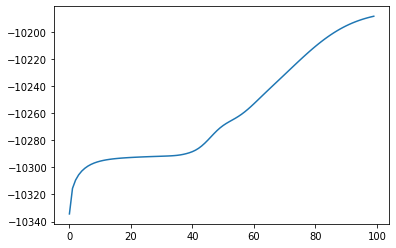

In [46]:
# plot of log likelihood over the course of all iterations
plt.plot(ll)

#### Two Dimensional Data

In [27]:
# Generate random 2D data with 5 clusters
X, m, c = generate_test_data(num_components=5,
                             num_dims=2,
                             num_cluster_points=1000)

In [28]:
# Check the shape of the data
print(str(X.shape))
print(m.shape)
print(c.shape)

(5000, 2)
(5, 2)
(2, 2)


In [29]:
# do the EM algorithm
_ ,_ , ll = EM(data=X,
            num_components=5,
            num_dims=2,
            num_iterations=100,
            plot_steps=False,
            save_figs=True)

100%|██████████| 100/100 [04:25<00:00,  2.65s/it]


<Figure size 576x576 with 0 Axes>

In [31]:
# save images as gif to show below
save_as_gif(output_folder="./gifs/2dim5cluster.gif")

![SegmentLocal](gifs/2dim5cluster.gif "segment")

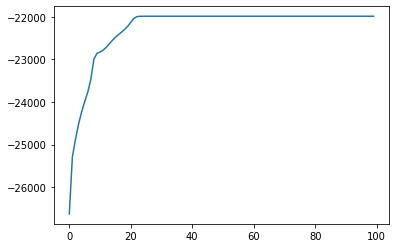

In [32]:
# plot of log likelihood over the course of all iterations
plt.plot(ll)

### Higher Dimensional data

In [55]:
# generate 4 dimensional data
X, m, c = generate_test_data(num_components=5,
                             num_dims=4,
                             num_cluster_points=100)
# Check the shape of the data
print(str(X.shape))
print(m.shape)
print(c.shape)
# do the EM algorithm
components_params,_ , ll = EM(data=X,
            num_components=5,
            num_dims=4,
            num_iterations=100,
            plot_steps=False,
            save_figs=False)

(500, 4)
(5, 4)
(4, 4)


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


In [56]:
# show mean values of original data
m

array([[ 9.31713021,  9.34769086, -6.01660863, -2.19722899],
       [ 0.14420667,  5.00329823,  4.01777596,  7.17019503],
       [-3.81798961, -2.56851288, -2.48282002, -1.77668688],
       [ 4.76295417, -8.8837793 , -3.49114333, -5.11678863],
       [ 0.91325714,  4.42146009, -2.09300781, -3.33928974]])

In [57]:
# show mean values of estimated gaussians to see if they fit those of the original data
[param["m"] for param in components_params]

[array([-3.7044629 , -2.68812835, -2.13922796, -1.64127365]),
 array([ 0.72933076,  4.48695329, -2.34666913, -3.45401525]),
 array([0.3163736 , 5.3294941 , 4.35869835, 7.0763938 ]),
 array([ 9.13007342,  9.25824709, -6.05431279, -2.24197559]),
 array([ 4.84088498, -8.90073281, -3.53062758, -5.16529718])]

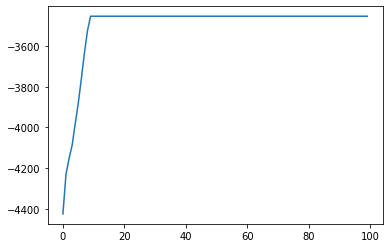

In [58]:
# plot log likelihoods
plt.plot(ll)
plt.show()

# Experiment

In [8]:
# To plot the original data, every datapoint of a cluster has the same color
def plot_original(data, samples_per_cluster, num_clusters):
    for i in range(0, num_clusters):
        plt.scatter(data[samples_per_cluster * i: samples_per_cluster * (i + 1), 0], data[samples_per_cluster * i: samples_per_cluster * (i + 1), 1])
    plt.show()

In [9]:
# constant values to have everything computed properly down below
CLUSTER_POINTS=100
NUM_COMPONENTS=5

In [15]:
# convenience function to have everyhing together, original data is just many gaussians appended, so true labels are "computed" based on this
def generate_data_for_test():
    true_labels = []
    for i in range(0,NUM_COMPONENTS):
        true_labels.extend([i for _ in range(0,CLUSTER_POINTS)])
    return generate_test_data(num_components=NUM_COMPONENTS,
                             num_dims=2,
                             num_cluster_points=CLUSTER_POINTS)[0], true_labels


X, true_labels = generate_data_for_test()
# Check the shape of the data
print(str(X.shape))

(500, 2)


In [16]:
# convenience functions
# predictions for em is the maximum likelihood of every row
def do_em(iterations=100):
    """
    do specified number of iterations with em with fixed parameters matching those of the kmeans
    :param iterations: number of iterations before stop
    :return: the labels, as well as the rand index score
    """
    labels = []
    _, responsibilities, _ = EM(data=X,
                               num_components=NUM_COMPONENTS,
                               num_dims=2,
                               num_iterations=iterations,
                               plot_steps=False,
                               save_figs=False)

    for row in responsibilities.tolist():
        max_val = max(row)
        labels.append(row.index(max_val))

    return labels, rand_score(true_labels, labels)

# convenience function
def do_kmeans():
    """
    do kmeans with 50 iterations before stop
    :return: the labels, as well as the rand index score
    """
    kmeans = KMeans(n_clusters=NUM_COMPONENTS, n_init=1, max_iter=50)
    labels = kmeans.fit_predict(X)

    return labels, rand_score(true_labels, labels)

## EM

100%|██████████| 50/50 [00:12<00:00,  3.85it/s]

Original Clustering:


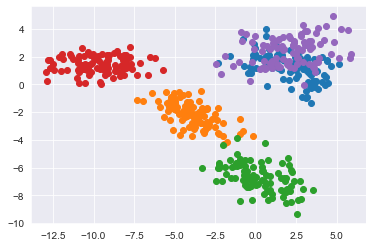

Predicted Clustering:


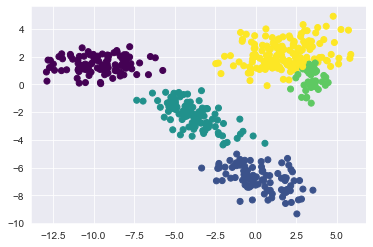

Score: 0.9209458917835671


In [19]:
# plot original and em predicted to check if everything works
labels, score = do_em(iterations=50)
print("Original Clustering:")
plot_original(X, CLUSTER_POINTS, NUM_COMPONENTS)
print("Predicted Clustering:")
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis")
plt.show()
print("Score:", score)

# KMeans

Original Clustering:


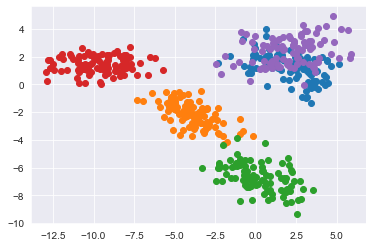

Predicted Clustering:


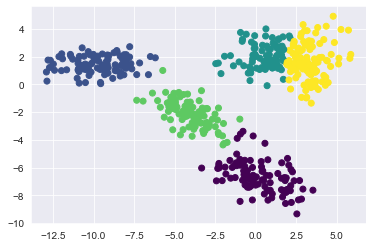

Score: 0.9119839679358718


In [20]:
# same with the kmeans
labels, score = do_kmeans()
print("Original Clustering:")
plot_original(X, CLUSTER_POINTS, NUM_COMPONENTS)
print("Predicted Clustering:")
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis")
plt.show()
print("Score:", score)

## Evaluate Score over many Iterations

In [13]:
NUMBER_OF_ITERATIONS = 100

In [14]:
# repeat kmeans 100 times with new data on every step and compute average rand index score
score = 0
for _ in range(0, NUMBER_OF_ITERATIONS):
    X, true_labels = generate_data_for_test()
    score += do_kmeans()[1]
print("Average Rand Score: ", score/NUMBER_OF_ITERATIONS)


Average Rand Score:  0.92689002004008


In [17]:
# repeat em 100 times with new data on every step and compute average rand index score
# restart if singular matrix
score = 0
iters = NUMBER_OF_ITERATIONS
while iters > 0:
    X, true_labels = generate_data_for_test()
    try:
        score += do_em(50)[1]
        iters -= 1
    except:
        print("singular matrix, restart")
        pass
print("Average Rand Score: ", score/NUMBER_OF_ITERATIONS)

 24%|██▍       | 12/50 [00:02<00:07,  4.96it/s]


singular matrix, restart


 12%|█▏        | 6/50 [00:01<00:09,  4.74it/s]


singular matrix, restart


  4%|▍         | 2/50 [00:00<00:10,  4.58it/s]


singular matrix, restart


  2%|▏         | 1/50 [00:00<00:09,  5.10it/s]


singular matrix, restart


  6%|▌         | 3/50 [00:00<00:09,  5.19it/s]


singular matrix, restart


 10%|█         | 5/50 [00:01<00:09,  4.80it/s]


singular matrix, restart


  2%|▏         | 1/50 [00:00<00:12,  3.79it/s]


singular matrix, restart


  4%|▍         | 2/50 [00:00<00:15,  3.08it/s]


singular matrix, restart


 26%|██▌       | 13/50 [00:02<00:07,  4.83it/s]


singular matrix, restart


 20%|██        | 10/50 [00:02<00:08,  4.50it/s]


singular matrix, restart


 20%|██        | 10/50 [00:02<00:08,  4.48it/s]


singular matrix, restart


  4%|▍         | 2/50 [00:00<00:09,  5.17it/s]


singular matrix, restart


  4%|▍         | 2/50 [00:00<00:10,  4.69it/s]


singular matrix, restart


 14%|█▍        | 7/50 [00:01<00:09,  4.61it/s]


singular matrix, restart


 16%|█▌        | 8/50 [00:01<00:08,  4.87it/s]


singular matrix, restart


 36%|███▌      | 18/50 [00:03<00:06,  5.07it/s]


singular matrix, restart


  4%|▍         | 2/50 [00:00<00:10,  4.73it/s]


singular matrix, restart


 20%|██        | 10/50 [00:02<00:08,  4.71it/s]


singular matrix, restart


 10%|█         | 5/50 [00:01<00:13,  3.35it/s]


singular matrix, restart


  2%|▏         | 1/50 [00:00<00:11,  4.40it/s]


singular matrix, restart


 10%|█         | 5/50 [00:01<00:09,  4.58it/s]


singular matrix, restart


 32%|███▏      | 16/50 [00:03<00:06,  4.94it/s]


singular matrix, restart


  4%|▍         | 2/50 [00:00<00:10,  4.74it/s]


singular matrix, restart


 10%|█         | 5/50 [00:01<00:09,  4.81it/s]


singular matrix, restart


  8%|▊         | 4/50 [00:00<00:09,  4.78it/s]


singular matrix, restart


 40%|████      | 20/50 [00:04<00:06,  4.92it/s]


singular matrix, restart


  2%|▏         | 1/50 [00:00<00:11,  4.41it/s]


singular matrix, restart


 14%|█▍        | 7/50 [00:01<00:08,  4.87it/s]


singular matrix, restart


  2%|▏         | 1/50 [00:00<00:12,  3.86it/s]


singular matrix, restart


  4%|▍         | 2/50 [00:00<00:10,  4.47it/s]


singular matrix, restart


  4%|▍         | 2/50 [00:00<00:10,  4.71it/s]


singular matrix, restart


100%|██████████| 50/50 [00:10<00:00,  4.89it/s]

Average Rand Score:  0.8871749098196393
